In [423]:
import numpy as np
import pandas as pd
from matplotlib import gridspec
from matplotlib import pylab as plt

In [425]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Paths
pheno_path = '/data1/abide/Pheno/pheno.csv'
pheno = pd.read_csv(pheno_path)

In [104]:
# Basic variables from the data
age_full = pheno['AGE_AT_SCAN'].values
age_min = np.min(age_full)
age_max = np.max(age_full)
site_list = [list(pheno.loc[pheno['SITE_ID'] == val]['AGE_AT_SCAN'].values) for val in pheno['SITE_ID'].unique()]
site_number = len(site_list)
age_range = age_max - age_min

In [107]:
def gen_window(win_range, box_number, start_age):
    """
    Generate a window for the uniform sampling
    """
    # And the divisions between the boxes
    window = np.zeros((2,box_number))
    # Generate the lower edges of the boxes
    window[0,:] = np.linspace(0, win_range, box_number, endpoint=False) + start_age
    window[1,:] = np.linspace(window[0,1], win_range+start_age, box_number)
    
    return window

In [5]:
def get_boxsubs(site, window):
    """
    Returns a vector of subject numbers
    corresponding to the boxes in window
    """
    # Get the number of boxes in the window
    box_number = window.shape[1]
    # Convert the site into an array
    site = np.array(site)
    # Compute the number of subjects in each box
    box_subs = [np.sum(np.logical_and(site>window[0,idx],site<=window[1,idx])) for idx in np.arange(box_number)]
    # Convert the number of box subs into an array
    box_subs = np.array(box_subs)
    
    return box_subs

In [386]:
def opt_sites(site_subs, uniform=True):
    """
    Find the optimal sites to maximize number 
    of subjects
    
    """
    # Get the number of sites
    site_number = site_subs.shape[0]
    box_number = site_subs.shape[1]
    # Get the smallest number per box
    min_subs = np.min(site_subs,1)
    # Sort the sites by subjects per box
    site_sort = np.argsort(min_subs)
    # Find the position of the last site with 
    # zero subjects
    last_zero = np.argwhere(min_subs[site_sort]==0)[-1]
    # Iteratively remove sites and see if 
    # the total number of subjects improves
    sub_vec = np.zeros((site_number,))
    for idx in np.arange(last_zero,site_number):
        # Slice the sites
        tmp_site_idx = site_sort[idx:]
        # See if we want the same number from all
        # sites or just within sites
        if uniform:
            # Get the number of remaining sites
            tmp_site_number = len(tmp_site_idx)
            # Get the minimal number of subjects
            tmp_min = np.min(site_subs[tmp_site_idx,:])
            # Get the total number of subjects
            tmp_total = tmp_min * tmp_site_number * box_number
        else:
            # We take the sum across all the sites
            # since we already dropped the ones with 
            # zero subjects
            tmp_sum = np.sum(np.min(site_subs[tmp_site_idx,:],1))
            # Get the total number of subjects
            tmp_total = tmp_sum * box_number
        sub_vec[idx] = tmp_total
    # Find the set of sites with the largest number
    # of subjects
    if np.max(sub_vec)==0:
        # None of the sites contribute, throw them all out
        max_idx = site_number
    else:
        max_idx = np.argmax(sub_vec)
    sites = site_sort[max_idx:]
            
    return sites

In [390]:
def opt_subjects(site_list, win_range, box_number, age_full, uniform=True, n_windows=40):
    """
    Optimizes the number of subjects across sites
    by generating and shifting a window of ages
    divided into boxes
    
    Returns:
        number of subjects
        optimal window
        list of sites
    """
    # Find the minimal and maximal age values
    age_min = np.min(age_full)
    age_max = np.max(age_full)
    age_range = age_max - age_min
    # Compute the window step
    win_shift = age_range - win_range
    win_step = win_shift / n_windows
    # Compute the starting ages for the windows
    start_ages = np.arange(0,win_shift+0.1, win_step) + age_min
    
    # Prepare a list for the results
    res_list = list()
    sub_vec = np.zeros((n_windows))
    # Iterate through the different windows and 
    # find the maximum number of subjects
    for win_id in np.arange(n_windows):
        start_age = start_ages[win_id]
        # Generate the window
        window = gen_window(win_range, box_number, start_age)
        # Iterate through sites and collect number 
        # of subjects per box for all of them
        site_subs = np.zeros((site_number, box_number))
        for s_id, site in enumerate(site_list):
            site_subs[s_id, :] = get_boxsubs(site, window)

        # Find the optimal sites for this window and box
        sites = opt_sites(site_subs, uniform)
        # Check if any sites are left
        if sites.size:
            # Check if uniform
            if uniform:
                # Compute the total number of subjects
                min_sub = np.min(site_subs[sites,:])
                total_subjects = min_sub * len(sites) * box_number
            else:
                # Take the sum of the minimal subjects numbers
                # at each site
                sum_sub = np.sum(np.min(site_subs[sites,:],1))
                total_subjects = sum_sub * box_number
        else:
            # There are no sites left
            min_sub = 0
            total_subjects = 0
        sub_vec[win_id] = total_subjects
        res_list.append((total_subjects, sites, window))
    
    # Get the optimal number of subjects
    max_sub_id = np.argmax(sub_vec)
    best_result = res_list[max_sub_id]
    
    return best_result

# Line by line experiment
To make sure the things behave

In [399]:
# Set the parameters needed for execution
heno_path = '/data1/abide/Pheno/pheno.csv'
pheno = pd.read_csv(pheno_path)

age_full = pheno['AGE_AT_SCAN'].values
site_list = [list(pheno.loc[pheno['SITE_ID'] == val]['AGE_AT_SCAN'].values) for val in pheno['SITE_ID'].unique()]

win_range = 1
box_number = 2
res = opt_subjects(site_list, win_range, box_number, age_full, False)

In [400]:
res

(78.0,
 array([12, 15,  7, 18, 11, 13, 17,  9,  6,  4, 14, 19, 16]),
 array([[ 13.53625,  14.03625],
        [ 14.03625,  14.53625]]))

## Draw an actual sample
So far, things have been quite theoretical. Let's get the details of the theoretical sample and make an actual list of subjects to be sure that we can really get a uniform sample of over 600 subjects.

First, I will change the function to return some information on the sample with the optimal number

In [404]:
pheno_path = '/data1/abide/Pheno/pheno.csv'
pheno = pd.read_csv(pheno_path)

age_full = pheno['AGE_AT_SCAN'].values
site_list = [list(pheno.loc[pheno['SITE_ID'] == val]['AGE_AT_SCAN'].values) for val in pheno['SITE_ID'].unique()]

windows = np.arange(1,30,0.5)
n_windows = len(windows)
boxes = np.arange(2,30)
n_boxes = len(boxes)

results = np.zeros((n_windows, n_boxes))
sites = np.zeros((n_windows, n_boxes))
res_list = list()
iter_id = 0
for w_id, win_range in enumerate(windows):
    for b_id, box_number in enumerate(boxes):
        res = opt_subjects(site_list, win_range, box_number, age_full, False)
        res_list.append(res)
        results[w_id, b_id] = res[0]
        sites[w_id, b_id] = len(res[1])

In [405]:
# Find the absolute maximum number of subjects
np.max(results)

480.0

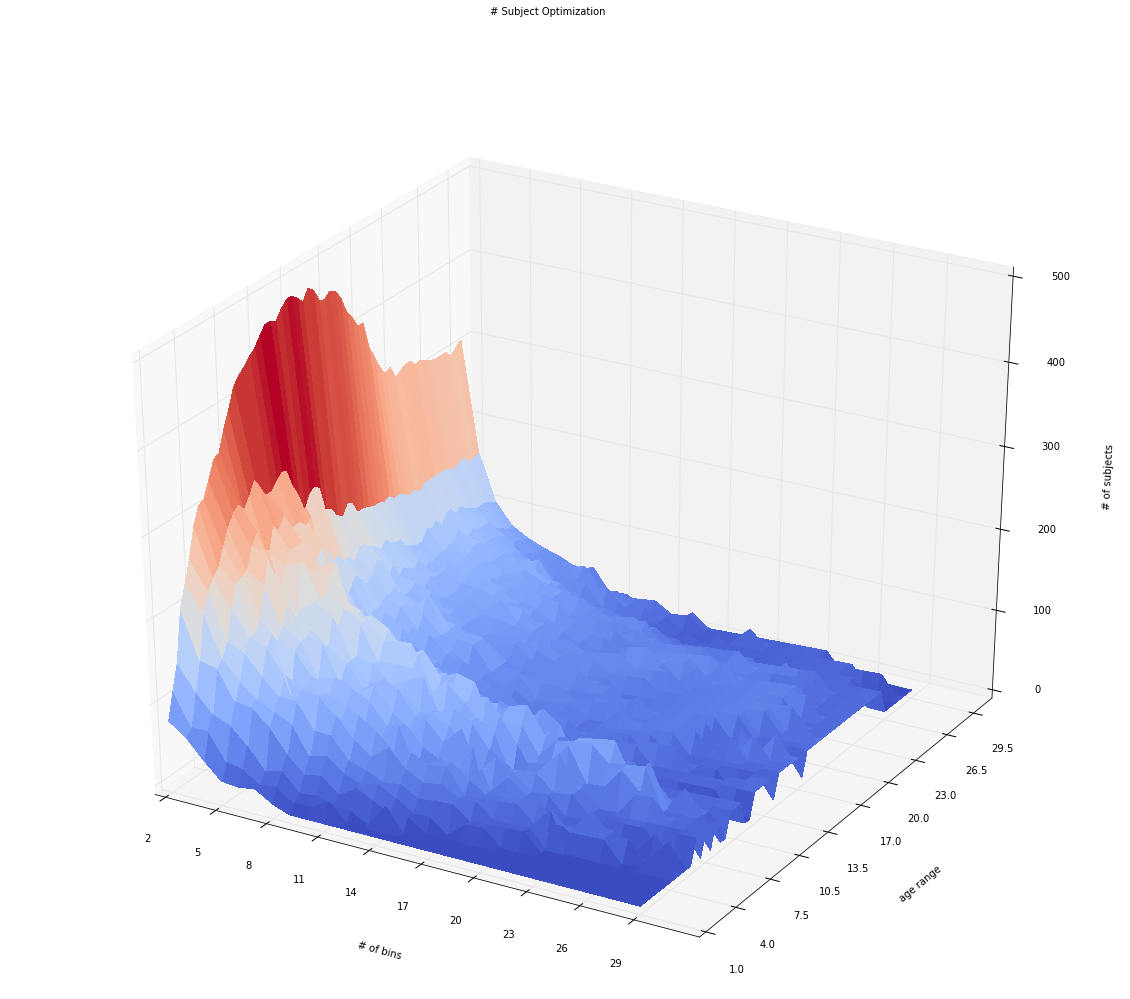

In [426]:
a, b = results.T.shape
X, Y = np.mgrid[:a, :b]

fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(1,1,1, projection='3d')
surf = ax.plot_surface(X,Y,results.T,rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0, antialiased=False)

x_ticks = np.round(np.linspace(0,len(boxes)-1,10))
x_labels = np.array([boxes[ind] for ind in x_ticks])
y_ticks = np.round(np.linspace(0,len(windows)-1,10))
y_labels = np.array([windows[ind] for ind in y_ticks])
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)

ax.set_xlabel('# of bins')
ax.set_ylabel('age range')
ax.set_zlabel('# of subjects')
fig.suptitle('# Subject Optimization')

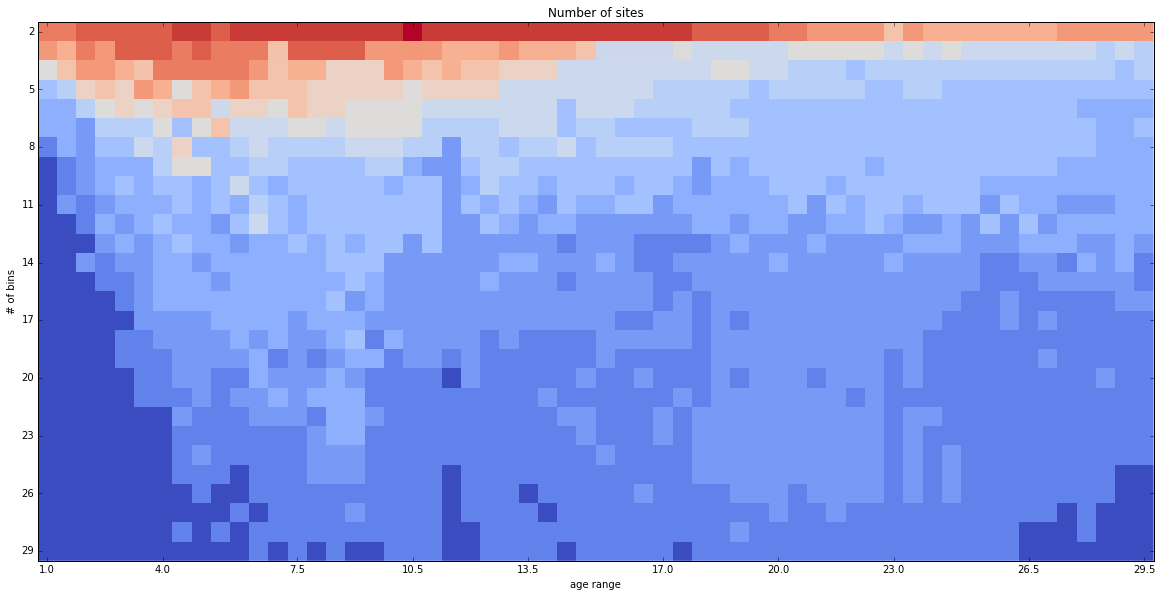

In [407]:
a, b = sites.T.shape
X, Y = np.mgrid[:a, :b]

fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(1,1,1)
surf = ax.imshow(sites.T, cmap=cm.coolwarm, interpolation='none')
ax.set_title('Number of sites')

ax.set_yticks(x_ticks)
ax.set_yticklabels(x_labels)
ax.set_xticks(y_ticks)
ax.set_xticklabels(y_labels)

ax.set_ylabel('# of bins')
ax.set_xlabel('age range')

In the corners we get all sites again because they none of them has any subjects in the bins and therefore none get's dropped. I need to fix that.

<matplotlib.colorbar.Colorbar instance at 0x27d93b90>

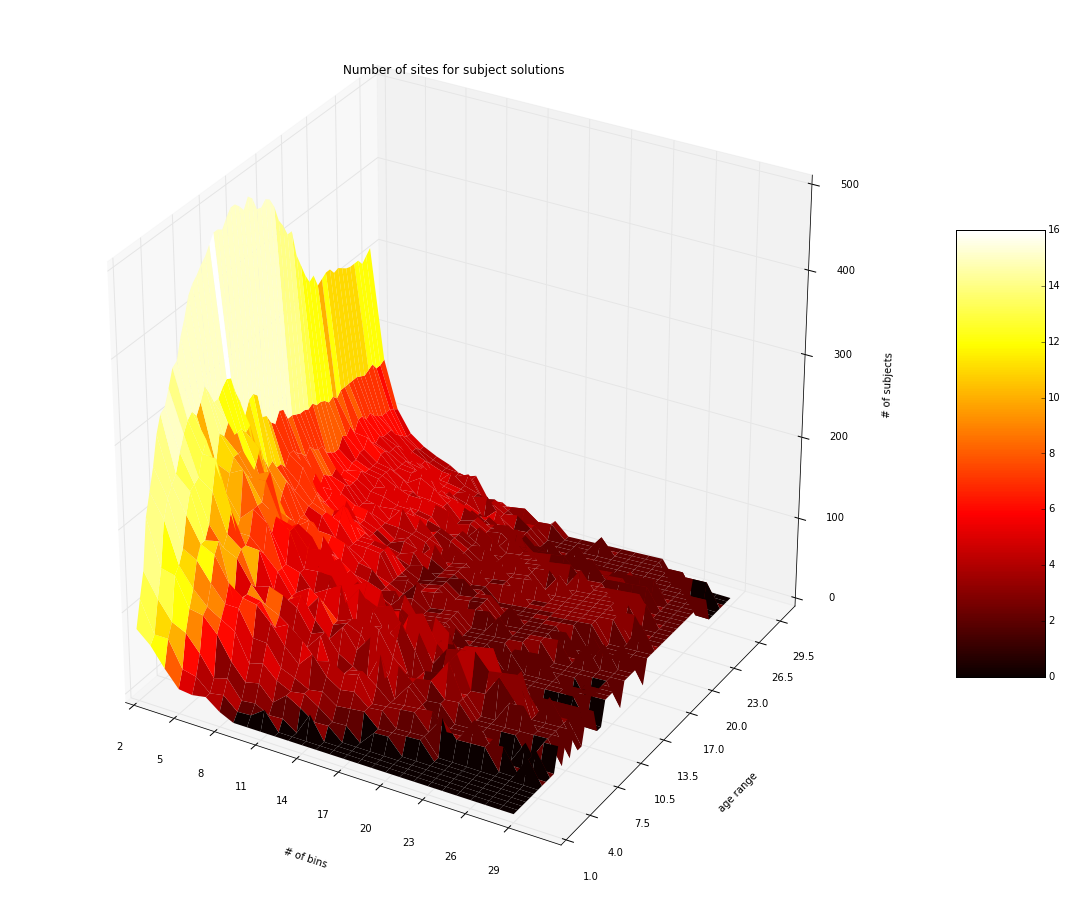

In [408]:
# Comnining them
a, b = results.T.shape
X, Y = np.mgrid[:a, :b]

fig = plt.figure(figsize=(20,16))
N = sites/np.max(sites)
ax = fig.add_subplot(1,1,1, projection='3d')
surf = ax.plot_surface(X,Y,results.T,rstride=1, cstride=1, cmap=cm.coolwarm,facecolors=cm.hot(N.T),
        linewidth=0, antialiased=True)
colmap = cm.ScalarMappable(cmap=cm.hot)
colmap.set_array(sites.T)

x_ticks = np.round(np.linspace(0,len(boxes)-1,10))
x_labels = np.array([boxes[ind] for ind in x_ticks])
y_ticks = np.round(np.linspace(0,len(windows)-1,10))
y_labels = np.array([windows[ind] for ind in y_ticks])
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)

ax.set_xlabel('# of bins')
ax.set_ylabel('age range')
ax.set_zlabel('# of subjects')
ax.set_title('Number of sites for subject solutions')
fig.colorbar(colmap, shrink=0.5, aspect=5)

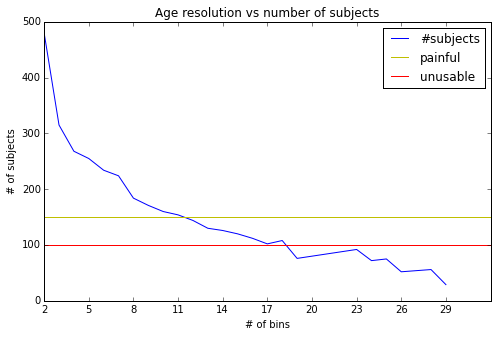

In [411]:
# Plot the number of subjects over the number of bins
x_ticks = np.round(np.linspace(0,len(boxes)-1,10))
x_labels = np.array([boxes[ind] for ind in x_ticks])
f = plt.figure(figsize=(8,5))
ax = f.add_subplot(111)
ax.plot(np.max(results,0), label='#subjects')
ax.axhline(y=150, color='y', label='painful')
ax.axhline(y=100, color='r', label='unusable')
ax.set_ylabel('# of subjects')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_xlabel('# of bins')
ax.legend()
ax.set_title('Age resolution vs number of subjects')

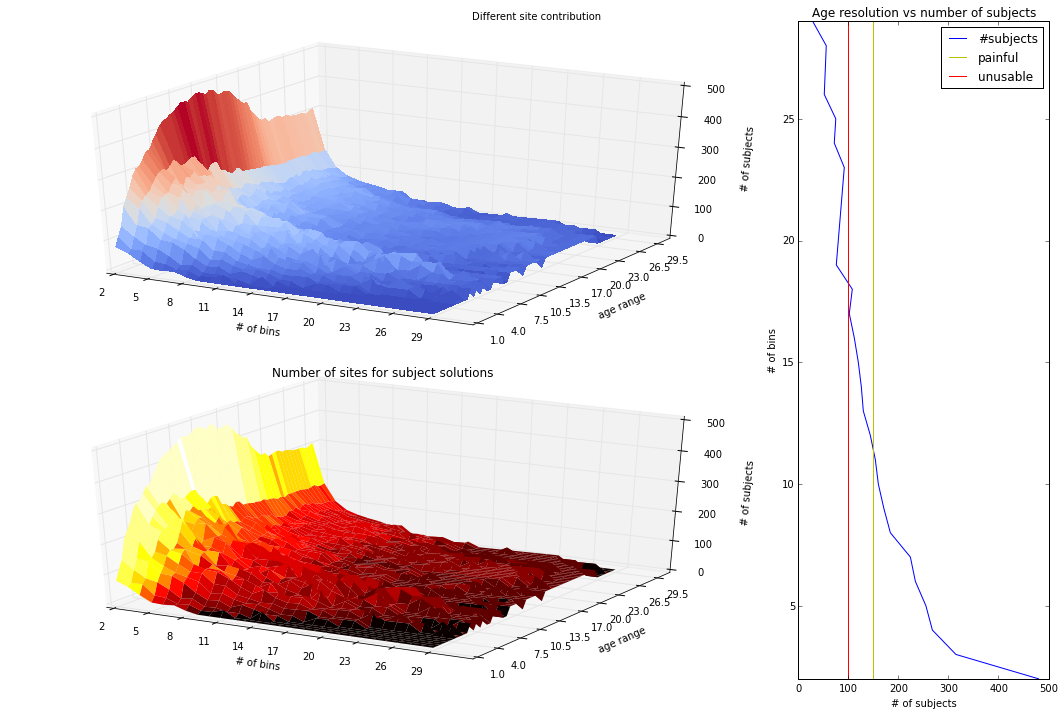

In [453]:
# Prepare stuff
x_ticks = np.round(np.linspace(0,len(boxes)-1,10))
x_labels = np.array([boxes[ind] for ind in x_ticks])
y_ticks = np.round(np.linspace(0,len(windows)-1,10))
y_labels = np.array([windows[ind] for ind in y_ticks])
a, b = results.T.shape
X, Y = np.mgrid[:a, :b]
N = sites/np.max(sites)

fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1]) 
# Make the subject overview
ax1 = fig.add_subplot(gs[0,0], projection='3d')
surf = ax1.plot_surface(X,Y,results.T,rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0, antialiased=False)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_labels)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_labels)
ax1.set_xlabel('# of bins')
ax1.set_ylabel('age range')
ax1.set_zlabel('# of subjects')

# Make the site overview
ax = fig.add_subplot(gs[1,0], projection='3d')
surf = ax.plot_surface(X,Y,results.T,rstride=1, cstride=1, cmap=cm.coolwarm,facecolors=cm.hot(N.T),
        linewidth=0, antialiased=True)
colmap = cm.ScalarMappable(cmap=cm.hot)
colmap.set_array(sites.T)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_xlabel('# of bins')
ax.set_ylabel('age range')
ax.set_zlabel('# of subjects')
ax.set_title('Number of sites for subject solutions')

# Show the boxes over subjects
ax3 = fig.add_subplot(gs[:,1])
ax3.plot(np.max(results,0),boxes, label='#subjects')
ax3.axvline(x=150, color='y', label='painful')
ax3.axvline(x=100, color='r', label='unusable')
ax3.set_ylim([np.min(boxes), np.max(boxes)])
ax3.set_xlabel('# of subjects')
ax3.set_ylabel('# of bins')
ax3.legend()
ax3.set_title('Age resolution vs number of subjects')
plt.tight_layout()
fig.suptitle('Different site contribution')

In [454]:
pheno_path = '/data1/abide/Pheno/pheno.csv'
pheno = pd.read_csv(pheno_path)

age_full = pheno['AGE_AT_SCAN'].values
site_list = [list(pheno.loc[pheno['SITE_ID'] == val]['AGE_AT_SCAN'].values) for val in pheno['SITE_ID'].unique()]

windows = np.arange(1,30,0.5)
n_windows = len(windows)
boxes = np.arange(2,30)
n_boxes = len(boxes)

results = np.zeros((n_windows, n_boxes))
sites = np.zeros((n_windows, n_boxes))
res_list = list()
iter_id = 0
for w_id, win_range in enumerate(windows):
    for b_id, box_number in enumerate(boxes):
        res = opt_subjects(site_list, win_range, box_number, age_full, True)
        res_list.append(res)
        results[w_id, b_id] = res[0]
        sites[w_id, b_id] = len(res[1])

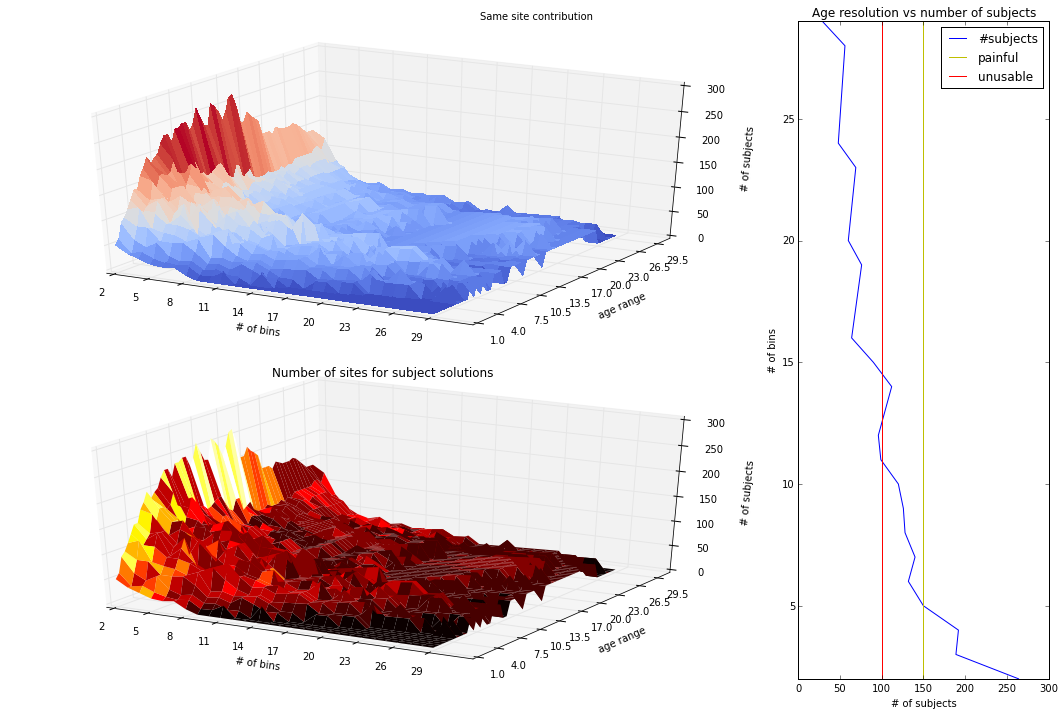

In [456]:
# Prepare stuff
x_ticks = np.round(np.linspace(0,len(boxes)-1,10))
x_labels = np.array([boxes[ind] for ind in x_ticks])
y_ticks = np.round(np.linspace(0,len(windows)-1,10))
y_labels = np.array([windows[ind] for ind in y_ticks])
a, b = results.T.shape
X, Y = np.mgrid[:a, :b]
N = sites/np.max(sites)

fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1]) 
# Make the subject overview
ax1 = fig.add_subplot(gs[0,0], projection='3d')
surf = ax1.plot_surface(X,Y,results.T,rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0, antialiased=False)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_labels)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_labels)
ax1.set_xlabel('# of bins')
ax1.set_ylabel('age range')
ax1.set_zlabel('# of subjects')

# Make the site overview
ax = fig.add_subplot(gs[1,0], projection='3d')
surf = ax.plot_surface(X,Y,results.T,rstride=1, cstride=1, cmap=cm.coolwarm,facecolors=cm.hot(N.T),
        linewidth=0, antialiased=True)
colmap = cm.ScalarMappable(cmap=cm.hot)
colmap.set_array(sites.T)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_xlabel('# of bins')
ax.set_ylabel('age range')
ax.set_zlabel('# of subjects')
ax.set_title('Number of sites for subject solutions')

# Show the boxes over subjects
ax3 = fig.add_subplot(gs[:,1])
ax3.plot(np.max(results,0),boxes, label='#subjects')
ax3.axvline(x=150, color='y', label='painful')
ax3.axvline(x=100, color='r', label='unusable')
ax3.set_ylim([np.min(boxes), np.max(boxes)])
ax3.set_xlabel('# of subjects')
ax3.set_ylabel('# of bins')
ax3.legend()
ax3.set_title('Age resolution vs number of subjects')
plt.tight_layout()
fig.suptitle('Same site contribution')

Get the optimal result from the results array. I'll get the 1D and the 2D index

In [227]:
ind2D = np.unravel_index(results.argmax(), results.shape)
ind1D = np.argmax(results)

Find the window length and the number of boxes

In [265]:
# Summary of optimal results
sub_num = results[ind2D]
window_length = windows[ind2D[0]]
box_number = boxes[ind2D[1]]
site_num = len(res_list[ind1D][1])
good_sites = list(pheno['SITE_ID'].unique()[res_list[ind1D][1]])
min_sub = res_list[ind1D][3]
print('Optimal Results:\n'
      '  number of subjects: {}\n'
      '  window length: {}\n'
      '  box number: {}\n'
      '  min sub: {}\n'
      '  site number: {}\n'
      '  sites: {}'.format(sub_num, window_length,
                           box_number, min_sub,
                           site_num,good_sites))

Optimal Results:
  number of subjects: 264.0
  window length: 18.0
  box number: 2
  min sub: 12.0
  site number: 11
  sites: ['SDSU', 'YALE', 'MAX_MUN', 'OLIN', 'UCLA_1', 'UM_2', 'USM', 'TRINITY', 'PITT', 'UM_1', 'NYU']


All nice and dandy but let's try to not force all sites to have the same amount of subjects in the cells and include anyone as long as they are all uniform within the boxes within a site.